In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV

cnt             1.000000
t1              0.388798
t2              0.369035
wind_speed      0.116295
is_holiday     -0.051698
is_weekend     -0.096499
season         -0.116180
weather_code   -0.166633
hum            -0.462901
Name: cnt, dtype: float64


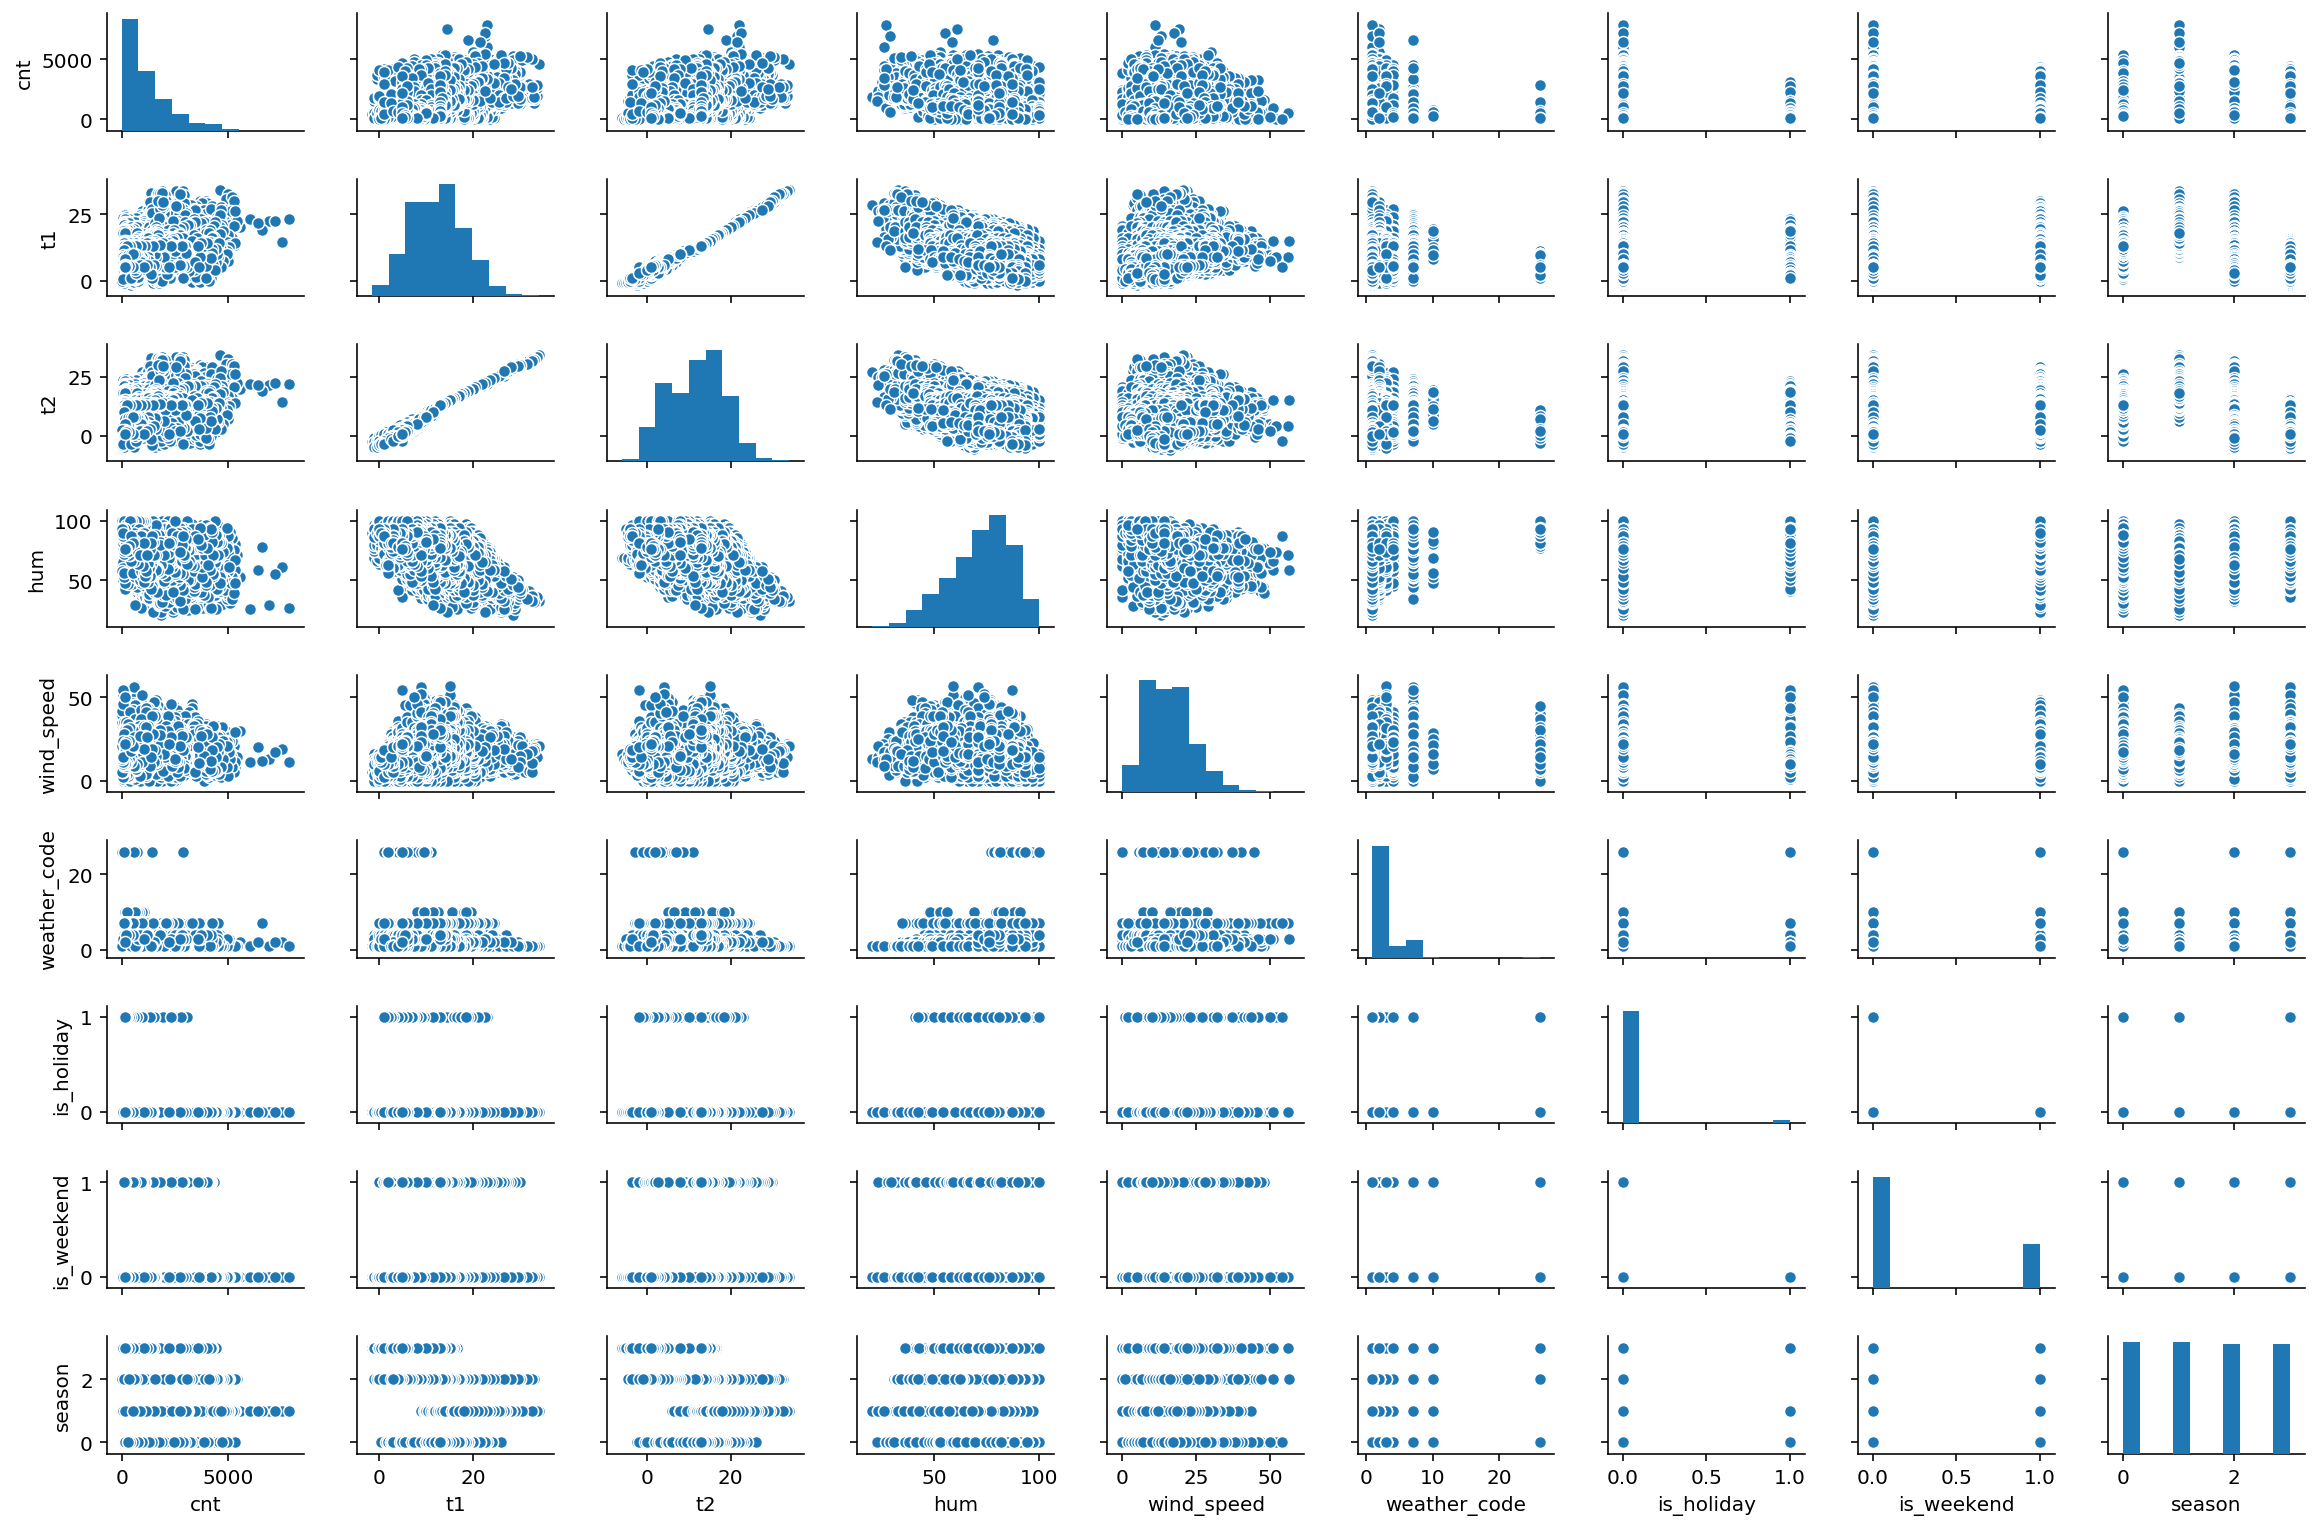

In [3]:
df = pd.read_csv('london_merged.csv')
#print the sorted correlation with my predicting variable,cnt
print(df.corr()['cnt'].sort_values(ascending=False))
sns.pairplot(df, height = 1.2, aspect=1.5)

The dataset contains information for bike shares in london. The variable that I'm trying to predict is the count of the bike share which is denoted as cnt in the dataset columns. No data cleaning is necessary and all the rows and columns have complete data. According to the pairplot, it seems like the temperature(t1) and the actual temperature(t2) it feels are most positively correlated with my predictor variable and humidity is most negatively correlated. Now, I want to take a closer look at the distribution of the count of bike shares.

Text(0.5, 1.0, 'Distribution of cnt')

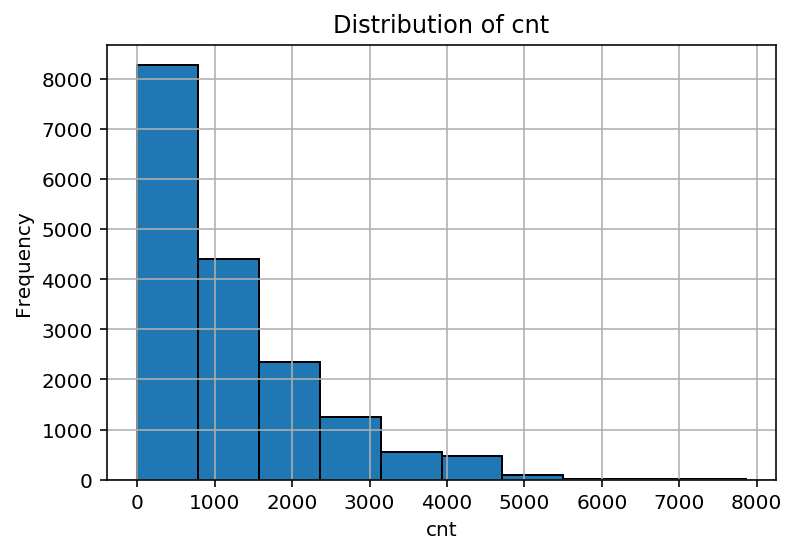

In [4]:
hist = df['cnt'].hist(edgecolor = 'black')
plt.xlabel('cnt')
plt.ylabel('Frequency')
plt.title('Distribution of cnt')

Taking a closer look at the distribution of cnt, it looks relatively skewed right since the majority count accumulates on the left. However, i decide not to take the log of the count values to fix the distribution into normal distribution because the count column contains zeros and values that are really close to zero. After taking the log of those unusual values, the new column will contain extremely large values that the system cannot handle further computations.

In [4]:
df = pd.read_csv('london_merged.csv')
categorical = df[['weather_code', 'is_holiday', 'is_weekend', 'season']]
y = df['cnt']
df = df.drop(columns = ['timestamp', 'cnt', 'weather_code', 'is_holiday', 'is_weekend', 'season'])
df.head()

,t1,t2,hum,wind_speed
0,3.0,2.0,93.0,6.0
1,3.0,2.5,93.0,5.0
2,2.5,2.5,96.5,0.0
3,2.0,2.0,100.0,0.0
4,2.0,0.0,93.0,6.5


Here, I split the data into numerical and categorical (I also don't need to tranform the categorical data into one hot column because the origional dataset has already transformed the categorical values into numerical values that I can use directly to fit the model later) in order to process the numerical variables into scaled polynoimal features.

In [31]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 4 columns):
t1            17414 non-null float64
t2            17414 non-null float64
hum           17414 non-null float64
wind_speed    17414 non-null float64
dtypes: float64(4)
memory usage: 544.3 KB


,t1,t2,hum,wind_speed
0,3.0,2.0,93.0,6.0
1,3.0,2.5,93.0,5.0
2,2.5,2.5,96.5,0.0
3,2.0,2.0,100.0,0.0
4,2.0,0.0,93.0,6.5


In [0]:
cor = pd.DataFrame(data={'X':df['t1'], 'y':df['cnt']})
plt.plot(cor['X'], cor['y'], '.')

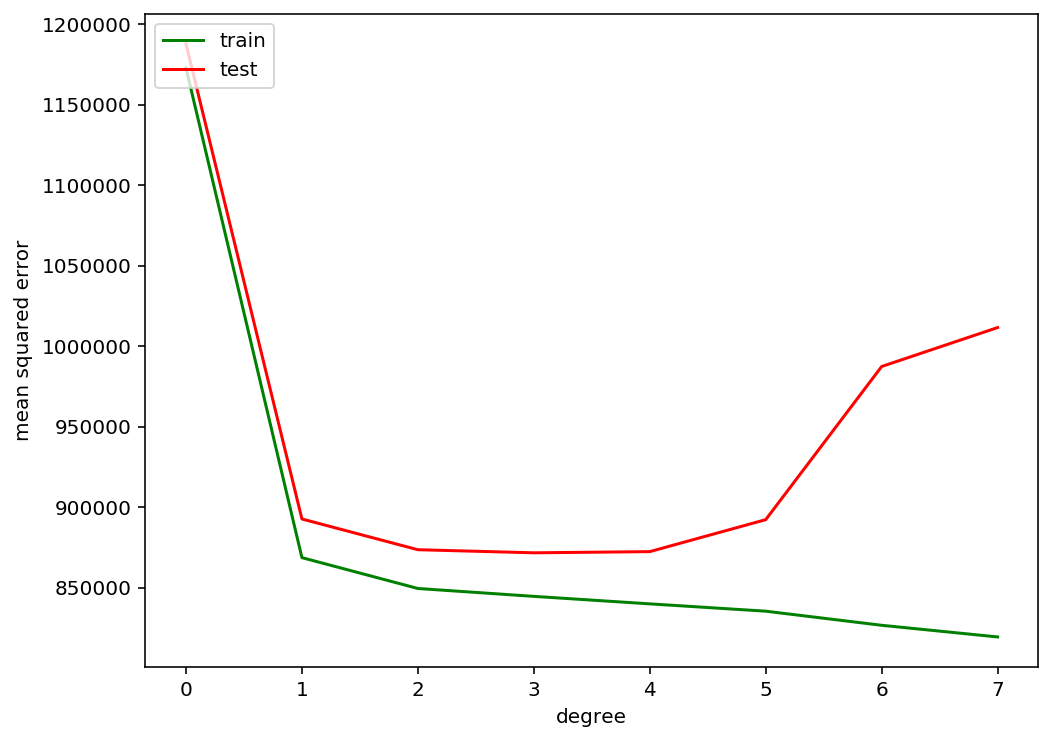

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

degrees = 8

train_error = []
test_error = []

for degree in range(degrees):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    train_error.append(mean_squared_error(y_train, model.predict(X_train)))
    test_error.append(mean_squared_error(y_test, model.predict(X_test)))
    
plt.figure(figsize=(8,6))
plt.plot(np.arange(degrees), train_error, color='green', label='train')
plt.plot(np.arange(degrees), test_error, color='red', label='test')
#plt.ylim((0.0, 1e0))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

Here I plot out the errors of training and testing data under different degree polynomial models. And it seems like the degrees from 2 to 5 are all good choices. Eventually, I decide to use 2 as the optimal degree for polynomial feature transformation on numerical data frame because degree 2 has the simpliest equation.

In [5]:
model = make_pipeline(PolynomialFeatures(2), StandardScaler())
model.fit(df)
X = categorical.join(pd.DataFrame(model.transform(df)))

In [6]:
#RidgeCV fitting
model = RidgeCV(cv=10, alphas=[0.0001,0.1,1,10])
model.fit(X,y)
model.score(X,y)
print(model.coef_)
print(model.intercept_)
print(model.alpha_)

[  -8.41221384 -253.09579464 -212.72455679   55.1406783     0.
  383.42408473  227.27238067 -233.29969734  118.15943579 -258.74898153
  -47.1214248   -35.76598216  401.49467852  212.05667119 -353.05171815
 -137.20690374   60.01598569 -111.69802022 -223.60247668]
1150.0251691232181
10.0


In order to understand what each coefficient represent to write out the final equation, I can print out the result of polynomial feature transformation that does not impose standard scalar.

In [14]:
### get rid of standard scaler momentarily only to see what columns correspond to t1, t2, t1^2, t2^2,...
model = make_pipeline(PolynomialFeatures(2))
model.fit(df)
X = categorical.join(pd.DataFrame(model.transform(df)))
X.head()

,weather_code,is_holiday,is_weekend,season,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.0,0.0,1.0,3.0,1.0,3.0,2.0,93.0,6.0,9.00,6.00,279.00,18.0,4.00,186.00,12.0,8649.00,558.0,36.00
1,1.0,0.0,1.0,3.0,1.0,3.0,2.5,93.0,5.0,9.00,7.50,279.00,15.0,6.25,232.50,12.5,8649.00,465.0,25.00
2,1.0,0.0,1.0,3.0,1.0,2.5,2.5,96.5,0.0,6.25,6.25,241.25,0.0,6.25,241.25,0.0,9312.25,0.0,0.00
3,1.0,0.0,1.0,3.0,1.0,2.0,2.0,100.0,0.0,4.00,4.00,200.00,0.0,4.00,200.00,0.0,10000.00,0.0,0.00
4,1.0,0.0,1.0,3.0,1.0,2.0,0.0,93.0,6.5,4.00,0.00,186.00,13.0,0.00,0.00,0.0,8649.00,604.5,42.25


After comparing with the origional dataset without any processing, I find that column 1 represents t1, column 2 represents t2, column 3 represents humidity, column 4 represents wind_speed, column 5 represents t1^2, column 6 represents t1*t2, column 7 represents t1*humidity, column 8 represents t1*wind_speed, column 9 represents t2^2, column 10 represents t2*humidity, column 11 represents t2*wind_speed, column 12 represents humidity^2, column 13 represents humidity*wind_speed, and column 14 represents wind_speed^2.

The equation can be written as: 

$ CNT = -8.4x_{weathercode} - 253.1x_{isholiday} - 212.7x_{isweekend}+55.1x_{seasoncode}+383.4x_{t1}+227.3x_{t2}-233.3x_{humidity}+118.2x_{windspeed}+...+1150 $

In [0]:
#LinearRegression fitting
model = LinearRegression()
model.fit(X_train, y_train)
print(f"R^2: {model.score(X_test,y_test)}")
print(f"Adjusted R^2: {1 - (1-model.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)}")